In [1]:
%run config.ipynb
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import spacy
import re
import featuretools as ft

# Data Filtering

In [2]:
business = pd.read_json("data/yelp_academic_dataset_business.json", lines=True)
checkin = pd.read_json("data/yelp_academic_dataset_checkin.json", lines=True)
review = pd.read_json("data/yelp_academic_dataset_review.json", lines=True)
# review = pd.read_csv("data/yelp_academic_dataset_sample_review.csv")
# review = pd.read_csv("data/yelp_academic_dataset_sample005_review.csv")
tip = pd.read_json("data/yelp_academic_dataset_tip.json", lines=True)
user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

### For User

In [3]:
user.isnull().sum()

user_id               0
name                  0
review_count          0
yelping_since         0
useful                0
funny                 0
cool                  0
elite                 0
friends               0
fans                  0
average_stars         0
compliment_hot        0
compliment_more       0
compliment_profile    0
compliment_cute       0
compliment_list       0
compliment_note       0
compliment_plain      0
compliment_cool       0
compliment_funny      0
compliment_writer     0
compliment_photos     0
dtype: int64

It seems no missing value here

In [4]:
user["total_compliments"] = user["compliment_hot"] + user["compliment_more"] + user["compliment_profile"] + user["compliment_cute"] + \
                            user["compliment_list"] + user["compliment_note"] + user["compliment_plain"] + user["compliment_cool"] + \
                            user["compliment_funny"] + user["compliment_writer"] + user["compliment_photos"]
        
def num_year(data):
    return data.count(',') + 1 if data else 0
user["elite"] = user["elite"].apply(num_year)

user_filter = user[["user_id", "review_count", "elite", "friends", "fans", "average_stars", "total_compliments"]]
user_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            object 
 1   review_count       int64  
 2   elite              int64  
 3   friends            object 
 4   fans               int64  
 5   average_stars      float64
 6   total_compliments  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 105.1+ MB


### For Review

In [5]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8021122 entries, 0 to 8021121
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        int64         
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 550.8+ MB


In [6]:
review = review.sample(frac=0.125)

In [7]:
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [8]:
review_filter = review[["review_id", "user_id", "business_id", "stars", "text"]]
review_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002640 entries, 4854856 to 2701346
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   review_id    1002640 non-null  object
 1   user_id      1002640 non-null  object
 2   business_id  1002640 non-null  object
 3   stars        1002640 non-null  int64 
 4   text         1002640 non-null  object
dtypes: int64(1), object(4)
memory usage: 45.9+ MB


### For Business

In [9]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


In [11]:
business_filter = business[["business_id", "name", "categories"]]
business_filter["business_stars"] = business["stars"]
business_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   business_id     209393 non-null  object 
 1   name            209393 non-null  object 
 2   categories      208869 non-null  object 
 3   business_stars  209393 non-null  float64
dtypes: float64(1), object(3)
memory usage: 6.4+ MB


### Merging

In [12]:
user_filter.columns = [i if '_id' in i else 'user_'+i for i in user_filter.columns]
user_filter.columns

Index(['user_id', 'user_review_count', 'user_elite', 'user_friends',
       'user_fans', 'user_average_stars', 'user_total_compliments'],
      dtype='object')

In [13]:
review_filter.columns = [i if '_id' in i else 'review_'+i for i in review_filter.columns]
review_filter.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'review_text'], dtype='object')

In [14]:
business_filter.columns = [i if '_id' in i or 'business' in i else 'business_'+i for i in business_filter.columns]
business_filter.columns

Index(['business_id', 'business_name', 'business_categories',
       'business_stars'],
      dtype='object')

In [15]:
df = review_filter.merge(user_filter, on='user_id')

In [16]:
df = df.merge(business_filter, on='business_id')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002640 entries, 0 to 1002639
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   review_id               1002640 non-null  object 
 1   user_id                 1002640 non-null  object 
 2   business_id             1002640 non-null  object 
 3   review_stars            1002640 non-null  int64  
 4   review_text             1002640 non-null  object 
 5   user_review_count       1002640 non-null  int64  
 6   user_elite              1002640 non-null  int64  
 7   user_friends            1002640 non-null  object 
 8   user_fans               1002640 non-null  int64  
 9   user_average_stars      1002640 non-null  float64
 10  user_total_compliments  1002640 non-null  int64  
 11  business_name           1002640 non-null  object 
 12  business_categories     1002378 non-null  object 
 13  business_stars          1002640 non-null  float64
dtypes:

In [18]:
df = df[~df["business_categories"].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002378 entries, 0 to 1002639
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   review_id               1002378 non-null  object 
 1   user_id                 1002378 non-null  object 
 2   business_id             1002378 non-null  object 
 3   review_stars            1002378 non-null  int64  
 4   review_text             1002378 non-null  object 
 5   user_review_count       1002378 non-null  int64  
 6   user_elite              1002378 non-null  int64  
 7   user_friends            1002378 non-null  object 
 8   user_fans               1002378 non-null  int64  
 9   user_average_stars      1002378 non-null  float64
 10  user_total_compliments  1002378 non-null  int64  
 11  business_name           1002378 non-null  object 
 12  business_categories     1002378 non-null  object 
 13  business_stars          1002378 non-null  float64
dtypes:

In [19]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars
0,lXSEWDtaiaQcxj5Nuxx6JA,fWqtOUpCFv6rmaacYZdkEQ,0z010Dfuv-PLUIukFhYEHQ,5,Great spot. Matt is da Bomb. Fair price for go...,55,0,None,0,2.95,2,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0


In [20]:
df.to_csv("data/yelp_academic_dataset_sample0125_filter.csv", index=False)

# Preprocessing

In [2]:
df = pd.read_csv("data/yelp_academic_dataset_sample0125_filter.csv")

### Text Cleaning

In [3]:
nlp = spacy.load("en_core_web_lg")
stop_words = set(stopwords.words('english')) 

In [4]:
SYMBOL_RE = re.compile('[/(){}\[\]\|@,.:!?;\-*]')
# website regex is from https://regexr.com/3e4a2
WEBSITES_RE = re.compile('(https?:\/\/)?(www\.)[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)| \
                         (https?:\/\/)?(www\.)?(?!ww)[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,4}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
ABBR_RE = re.compile('[a-z]*[\'][^ ]*')
def clean_text(text):
    text = text.lower()

    text = WEBSITES_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    text = SYMBOL_RE.sub('', text)
    text = ABBR_RE.sub('', text)

    # remove entities as they are meaningless in most times
    for ent in nlp(text).ents:
        text = text.replace(str(ent), '')
        
    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in stripped]
    text = ' '.join(word for word in stemmed if word.isalpha())
    
    return text

In [5]:
%%time
# run the commented line if you want to reproduce the X
# Note: This process will a long time to run, so make sure you create a copy yourself after finish
# Skip this cell to the next can get the result
df["review_text_after_cleaning"] = df["review_text"].apply(clean_text)

Wall time: 3h 6min 28s


In [6]:
X = df["review_text_after_cleaning"]
X

0          great spot fair price good servic profession s...
1          hair facial alway feel incred welcom everyon g...
2          schedul minut late also schedul color girl fro...
3          thier custom open door thrill attent gave hair...
4          want great cut color word you quach start see ...
                                 ...                        
1002373    bank worst fountain hill wait time get servic ...
1002374    call plumb the owner call back ask problem cal...
1002375    superb custom servic excel product qualiti unm...
1002376    pizza good love atmospher wait go back tri sto...
1002377    ghost tour can not convey total wast time even...
Name: review_text_after_cleaning, Length: 1002378, dtype: object

### Data Cleaning

In [7]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,review_text_after_cleaning
0,lXSEWDtaiaQcxj5Nuxx6JA,fWqtOUpCFv6rmaacYZdkEQ,0z010Dfuv-PLUIukFhYEHQ,5,Great spot. Matt is da Bomb. Fair price for go...,55,0,None,0,2.95,2,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0,great spot fair price good servic profession s...


<AxesSubplot:xlabel='user_fans', ylabel='user_average_stars'>

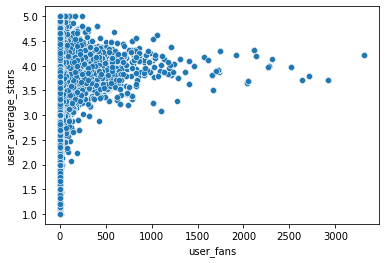

In [8]:
sns.scatterplot(x='user_fans', y='user_average_stars', data=df)

<AxesSubplot:xlabel='business_stars', ylabel='review_stars'>

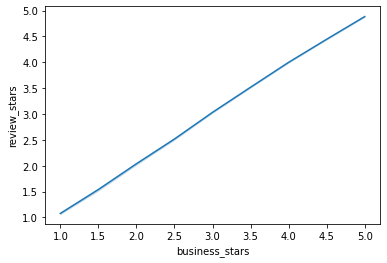

In [9]:
sns.lineplot(x='business_stars', y='review_stars', data=df)

In [10]:
df["review_stars"].unique()

array([5, 2, 4, 1, 3], dtype=int64)

In [11]:
df.isnull().sum()

review_id                     0
user_id                       0
business_id                   0
review_stars                  0
review_text                   0
user_review_count             0
user_elite                    0
user_friends                  0
user_fans                     0
user_average_stars            0
user_total_compliments        0
business_name                 0
business_categories           0
business_stars                0
review_text_after_cleaning    0
dtype: int64

<AxesSubplot:xlabel='review_stars', ylabel='size'>

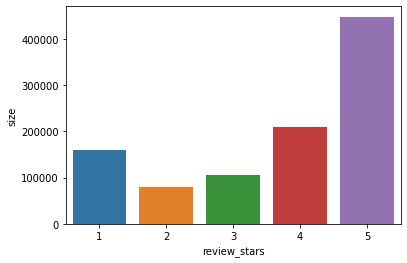

In [12]:
review_star_freq = df.groupby("review_stars", as_index=False).size()
sns.barplot(x="review_stars", y="size", data=review_star_freq)

Most users would like to give a high quality. Perhaps users may be more likely to write a comment and give stars when they had a good service

In [13]:
df["to_recommend"] = df["review_stars"].apply(lambda x : True if x == 5 else False)

<AxesSubplot:xlabel='business_stars', ylabel='to_recommend'>

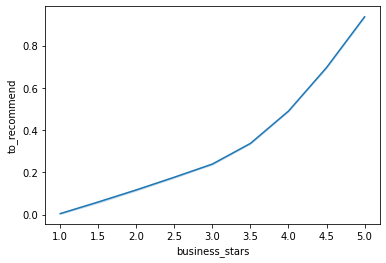

In [14]:
sns.lineplot(x='business_stars', y='to_recommend', data=df)

In [15]:
def num_user_friends(data):
    return data.count(',') + 1 if data != 'None' else 0

df["num_user_friends"] = df["user_friends"].apply(num_user_friends)

In [16]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,review_text_after_cleaning,to_recommend,num_user_friends
0,lXSEWDtaiaQcxj5Nuxx6JA,fWqtOUpCFv6rmaacYZdkEQ,0z010Dfuv-PLUIukFhYEHQ,5,Great spot. Matt is da Bomb. Fair price for go...,55,0,None,0,2.95,2,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0,great spot fair price good servic profession s...,True,0


In [17]:
df.to_csv("data/yelp_academic_dataset_sample0125_filter.csv", index=False)

In [22]:
df = pd.read_csv("data/yelp_academic_dataset_sample0125_filter.csv")

In [23]:
df.isnull().sum()

review_id                       0
user_id                         0
business_id                     0
review_stars                    0
review_text                     0
user_review_count               0
user_elite                      0
user_friends                    0
user_fans                       0
user_average_stars              0
user_total_compliments          0
business_name                   0
business_categories             0
business_stars                  0
review_text_after_cleaning    328
to_recommend                    0
num_user_friends                0
dtype: int64

In [24]:
df[df["review_text_after_cleaning"].isnull()]

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,review_text_after_cleaning,to_recommend,num_user_friends
8764,_0ca8566X8NNfQfpwWY3dQ,qDxrWaeD1-_uJEIj4ZDsSQ,slUn4AINGy3QmDK62YGzoA,1,差評，等了一個小時，連后面的客人吃飽走了，還沒有上菜，只有一壶茶，我也是在美國幾十年了，餐飲...,11,0,None,0,2.91,1,China Mama,"Restaurants, Chinese",4.5,NaN,False,0
9934,RWJyJHTCzQMTqS4mJaFLBw,NOil0njjZB7SIojAtPI_Wg,Y5-Gphj7DNIav1ZADUip-A,5,Comment ne pas aimer le Marché Jean-Talon?,15,0,None,0,3.44,1,Marché Jean-Talon,"Shopping, Public Markets, Food, Grocery, Farme...",4.5,NaN,True,0
9983,ti-Ws-uLBamXoPlc0dFbcg,rIzFbmSVEn0SbMXV2RS1BA,Y5-Gphj7DNIav1ZADUip-A,5,Mon marché préféré! De beaux produits à prix a...,352,4,"tBBxgF5yCkHiEvSE3d-kXw, YYn_0gtYwafr6b6I9UG4mg...",12,3.61,384,Marché Jean-Talon,"Shopping, Public Markets, Food, Grocery, Farme...",4.5,NaN,True,147
10637,tWoeks88YiiEJMdTm1pQ7A,8JWBGvFTYSgQrLhRRTqppQ,fzHBvd0HZm1yB3UIMqZ3bA,1,首先不说菜如何 我们点了一份蟹粉包一份红油抄手麻辣牛筋和油条， 小笼包还好，牛筋太难吃了。更...,2,0,None,0,2.00,0,Ding Tai Fung,"Dim Sum, Specialty Food, Food, Chinese, Ethnic...",3.5,NaN,False,0
10664,oLQfIBR3EUPuKf5pc2J5PA,X-uefJdU44ctKNdB80qqAQ,kNnFjsxNv_OkvK4GLRTBJg,4,因為我係住喺downtown，所以平時行街都係行eaton centre。難得今個週末上up...,89,0,"l7AM4HoSSQ2ulDDmmwnTcA, CQ67NJigSe5-uBDX3b_CUw...",2,3.70,2,Markville Shopping Centre,"Shopping, Shopping Centers",3.5,NaN,False,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989988,32ePVfSRVA8rW1JaaQWPIQ,w9jkvfUBmJkixL6ur3ef9Q,X6ek-toL9X89qE0nZLWSqw,4,Un classique!,4,0,"vno4e4k3pZdTZK4ctTElGA, LOqdrVuv1TbMyKsO_k21pQ...",0,3.75,0,Villa Pasta,"Restaurants, Italian",3.0,NaN,False,3
997884,DCFrLjuwtb1lZcsLkfCQrQ,nyhQseET_zIfWVhDd6sduQ,uGLAEGqeJa4jtP1Io0sOrg,5,Très bon restaurant de cuisine Asiatique fusio...,1,0,None,0,5.00,0,Mineral,"Beer, Wine & Spirits, Restaurants, Canadian (N...",4.5,NaN,True,0
999622,is3rg1U6RbF-jt5p0OIVow,ybsM3GDTOtHa2msP2NFB_w,sIx27ubGSnmrA_BcuKNaSA,5,Huyy que tienda muy limpia y muy buen servicio...,1,0,"f2FXhyjZ3qYjd_yh62yAYg, Tm_oTXOurllOaQqiLnjnzg...",0,5.00,0,Fry's Food Stores of Arizona,"Grocery, Food",2.0,NaN,True,4
1000986,hu1whXPTvCgYQz1W476Otg,ENWtgqMipKOJCQrqtuPqDw,8z1S900U2lYtABbwrHMDQg,3,Leur Poutine est excellente et le temps d'atte...,2,0,None,0,4.00,0,Centrale Bergham,"Restaurants, Fast Food, Burgers, Moroccan, Mid...",3.5,NaN,False,0


In [25]:
df = df[~df["review_text_after_cleaning"].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002050 entries, 0 to 1002377
Data columns (total 17 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   review_id                   1002050 non-null  object 
 1   user_id                     1002050 non-null  object 
 2   business_id                 1002050 non-null  object 
 3   review_stars                1002050 non-null  int64  
 4   review_text                 1002050 non-null  object 
 5   user_review_count           1002050 non-null  int64  
 6   user_elite                  1002050 non-null  int64  
 7   user_friends                1002050 non-null  object 
 8   user_fans                   1002050 non-null  int64  
 9   user_average_stars          1002050 non-null  float64
 10  user_total_compliments      1002050 non-null  int64  
 11  business_name               1002050 non-null  object 
 12  business_categories         1002050 non-null  object 
 1

In [5]:
user = pd.read_json("data/yelp_academic_dataset_user.json", lines=True)

In [8]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968703 entries, 0 to 1968702
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(16), object(5)
memory usage: 330.4+ MB


In [17]:
max(user["elite"].apply(lambda x : max(x.split(","))))

'2018'

In [21]:
minimum = user["elite"].apply(lambda x : min(x.split(",")))
mini = "2020"
for i in minimum:
    if i and i < mini:
        mini = i
mini

'2006'

In [27]:
data = df.merge(user[["user_id", "yelping_since", "elite"]], on="user_id")
data.head(1)

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,review_text_after_cleaning,to_recommend,num_user_friends,yelping_since,elite
0,lXSEWDtaiaQcxj5Nuxx6JA,fWqtOUpCFv6rmaacYZdkEQ,0z010Dfuv-PLUIukFhYEHQ,5,Great spot. Matt is da Bomb. Fair price for go...,55,0,None,0,2.95,2,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0,great spot fair price good servic profession s...,True,0,2012-05-03 17:53:15,
1,Au1-zoHWO3VIlI48blfixA,DlGBaNwQsAeKAW75iHVEzg,0z010Dfuv-PLUIukFhYEHQ,5,I've been coming here for years. Matt does my ...,15,0,"MCX2QsAl79d4-Z-H9YJPEw, DN0YgFN7S7teowvOC0mwNA...",2,3.60,1,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0,hair facial alway feel incred welcom everyon g...,True,531,2013-05-29 20:52:29,
2,7I47EEj6OSNnhMzmZ73jFA,DlGBaNwQsAeKAW75iHVEzg,HqDRvA64BpGtjnzf9beE4Q,1,We've been shopping at this specific Godiva fo...,15,0,"MCX2QsAl79d4-Z-H9YJPEw, DN0YgFN7S7teowvOC0mwNA...",2,3.60,1,Godiva Chocolatier,"Candy Stores, Food, Specialty Food",3.5,shop specif godiva encount employe aw stood st...,False,531,2013-05-29 20:52:29,
3,dw6k8HwpXBZ2xD_MC-9dDg,YBqPdDh0KOdAfMv_9U4jOw,0z010Dfuv-PLUIukFhYEHQ,2,I had one great haircut with Hugh and when I s...,8,0,"FC8HuS-i-8XDv0HFGVgnbQ, 66MQLCs9yP2PgKZLTck66Q...",0,1.75,0,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0,schedul minut late also schedul color girl fro...,False,22,2009-06-24 04:36:55,
4,uoUrrljzO60p4pLsbhzGxg,YBqPdDh0KOdAfMv_9U4jOw,fKlr9qNoV37WQJwQ826POg,2,Husband and I attended an investment seminar h...,8,0,"FC8HuS-i-8XDv0HFGVgnbQ, 66MQLCs9yP2PgKZLTck66Q...",0,1.75,0,Fogo de Chão Brazilian Steakhouse,"Restaurants, Brazilian, Food, Seafood, Steakho...",4.0,husband attend invest seminar salad bar full d...,False,22,2009-06-24 04:36:55,


In [35]:
diff = []
for i in data[data["user_elite"] >12]["elite"]:
    i = i.split(",")
    if len(set(i)) != len(i):
        diff.append(i)
diff

[]

In [34]:
data.iloc[4305]["elite"]

'2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018'

In [37]:
data["year"] = data["yelping_since"].apply(lambda x : x[:4])
data.head(1)

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,review_text_after_cleaning,to_recommend,num_user_friends,yelping_since,elite,year
0,lXSEWDtaiaQcxj5Nuxx6JA,fWqtOUpCFv6rmaacYZdkEQ,0z010Dfuv-PLUIukFhYEHQ,5,Great spot. Matt is da Bomb. Fair price for go...,55,0,None,0,2.95,2,Hydrate Salon and Spa,"Day Spas, Hair Salons, Beauty & Spas",4.0,great spot fair price good servic profession s...,True,0,2012-05-03 17:53:15,,2012


In [38]:
max(data["year"])

'2019'

In [39]:
min(data["year"])

'2004'

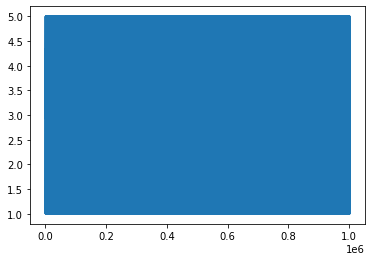

In [41]:
plt.plot(df["user_average_stars"])

In [42]:
max(df["user_average_stars"])

5.0

In [43]:
min(df["user_average_stars"])

1.0

In [44]:
df[df["user_average_stars"] == 5]

,review_id,user_id,business_id,review_stars,review_text,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars,review_text_after_cleaning,to_recommend,num_user_friends
19,2kM28v-eO41noBBgSf96nQ,vqtVgQaJ0quYkeBCsZ9reQ,cXgXRqB40CGHEMKQgxLDTg,5,If you want some bomb pizza with a kick ass st...,8,0,"dqU6aqwyo6oJMLILDyynpA, POpoUlUqzKQb-X0QUPlrFw...",0,5.0,0,Fired Pie,"Salad, Italian, Restaurants, Pizza",4.0,want bomb pizza kick ass staff highli recommen...,True,145
35,ZMUO71P9SBo32dJkqTQb7g,utJxQxaT-Ik0N4mNMqyPvA,cXgXRqB40CGHEMKQgxLDTg,5,Love their salads as well as their pizza! The...,8,0,None,0,5.0,0,Fired Pie,"Salad, Italian, Restaurants, Pizza",4.0,love salad well pizza gf friendli appreci loca...,True,0
59,TobxAgZ4zlh1ctm0rkLtmA,yYkk8mM5V33pX0x7FAD28g,cXgXRqB40CGHEMKQgxLDTg,5,First time here and must say that I love it......,1,0,zFp22UYxTFPmyFDjkSy7FQ,0,5.0,1,Fired Pie,"Salad, Italian, Restaurants, Pizza",4.0,time must say love itcreat pizza top turn real...,True,1
68,8HpIf2pRSYwVuqFWnmK5HA,-1lsjF90ZySTV8OjN30TCQ,XHnE__Oec_KDfGTJ7jrIpg,5,"Great wings, great service. Had my order in ju...",2,0,"BvtbCYJ9EZeJYK00cTPvYw, BJYZHzb3TGJdvNUS8h9CAQ...",0,5.0,1,Valley Wings,"Restaurants, Chicken Wings",4.5,order employe super nice definit back,True,45
74,JbkxOFApDqip2lBIyPNBZQ,5K3XmuGXEZb4PpQb-j6RFw,XHnE__Oec_KDfGTJ7jrIpg,5,We were very hopeful that this new place would...,14,0,vy6GvEdgbLxQM7990eTvnw,1,5.0,0,Valley Wings,"Restaurants, Chicken Wings",4.5,hope new place would make good replac previou ...,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002042,C0Pe6oU_zVdR8MbRtqAOJA,XrnFf18sBvIZFyj1t7JgoQ,Jp7DWno_5zAYtrpEkc0ylw,5,Loved Eat Well. Super yummy hand crafted healt...,2,0,None,0,5.0,1,Eat Well,"Restaurants, Vegan, Vegetarian",5.0,love eat well super yummi hand craft healthi f...,True,0
1002043,ke8BPZ1GQldGqM_qZ_qbXw,cKgtUD77PbudonVvHfu6Xg,BOgU_UFhgv7hDfzugKzLrg,5,"This being my first time at this cigar shop, I...",1,0,None,0,5.0,0,Cigar Studio,"Tobacco Shops, Shopping",3.0,time cigar shop enter high rate gotten well ye...,True,0
1002044,u6s9SJjMX3as2y3Dh_K6qg,86fInsTZrDGTDH2jmD-i2w,QmhK0eeBziRfFjnkYzXEHQ,5,I thoroughly enjoy shopping at this store beca...,1,0,None,0,5.0,0,Guess,"Accessories, Shopping, Women's Clothing, Fashion",3.0,thoroughli enjoy shop store employe well vario...,True,0
1002046,L3G9EylW6hHZB62oiOO0YA,BNusgXuMRxSbq1yxV_zqmw,V834f2ZLLNiDW9C5eKcqZg,5,Called Brecksville Plumbing on Tuesday. Jim (t...,4,0,"WK-_3YvfF627nfmLQ5v2rQ, 6IkkeIXCe_KPE1V6OQ-PKg...",0,5.0,0,Brecksville Plumbing,"Home Services, Water Heater Installation/Repai...",4.0,call plumb the owner call back ask problem cal...,True,118


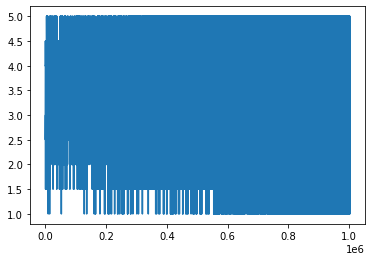

In [45]:
plt.plot(df["business_stars"])

In [46]:
set(df["business_stars"])

{1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [26]:
df.to_csv("data/yelp_academic_dataset_sample0125_filter.csv", index=False)

In [27]:
df[["review_id", "user_id", "business_id", "review_stars", "user_review_count", "user_elite", "user_friends", "user_fans", "user_average_stars", \
    "user_total_compliments", "business_name", "business_stars", "review_text_after_cleaning", "num_user_friends"]].to_csv("data/yelp_academic_dataset_final.csv", index=False)

### Feature Engineering 

In [11]:
df.head(1)

,review_id,user_id,business_id,review_stars,review_text,review_text_after_cleaning,user_review_count,user_elite,user_friends,user_fans,user_average_stars,user_total_compliments,business_name,business_categories,business_stars
0,yNB39szX3M8mTEzTtsgoCw,Y1iCYGvLf4ifPoXlKLGq-w,o2Qh4SiGYJ7BK4hP7dfkrw,5,This is an amazing indian Bistro!!I If I do sa...,amaz bistroi say myself never cuisin glad expe...,1,0,,0,5.0,0,Saffron Indian Bistro,"Restaurants, Indian",4.5


In [12]:
es = ft.EntitySet("yelp")
es = es.entity_from_dataframe(entity_id = 'review', dataframe = df, index = 'review_id')
# The following commented codes can be used for the raw dataset
# es = es.entity_from_dataframe(entity_id = 'user', dataframe = user, index = 'user_id')
# es = es.entity_from_dataframe(entity_id = 'review', dataframe = review, index = 'review_id')
# es = es.entity_from_dataframe(entity_id = 'tip', dataframe = tip, index = 'user_id')
# es = es.entity_from_dataframe(entity_id = 'business', dataframe = business, index = 'business_id')
# es = es.entity_from_dataframe(entity_id = 'check_in', dataframe = check_in, index = 'business_id')
es

Entityset: yelp
  Entities:
    review [Rows: 400807, Columns: 15]
  Relationships:
    No relationships

In [13]:
features, feature_names = ft.dfs(entityset = es, target_entity = 'review', agg_primitives = ['mean', 'max', 'percent_true', 'last'])

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400807 entries, yNB39szX3M8mTEzTtsgoCw to 26iv0bQ5o3oxzZOSayQPjQ
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   user_id                                     400807 non-null  object 
 1   business_id                                 400807 non-null  object 
 2   review_stars                                400807 non-null  int64  
 3   user_review_count                           400807 non-null  int64  
 4   user_elite                                  400807 non-null  int64  
 5   user_fans                                   400807 non-null  int64  
 6   user_average_stars                          400807 non-null  float64
 7   user_total_compliments                      400807 non-null  int64  
 8   business_name                               400807 non-null  object 
 9   business_stars                        

In [15]:
features["NUM_CHARACTERS(user_friends)"]

review_id
yNB39szX3M8mTEzTtsgoCw       0
wxvs5Ih03vWCiJ6va1zJgw    1102
3GwovpioE5iXOmTqpdKCfQ       0
ipWXT0F2bE0smebUADaVRw     838
yJHS5HcNtSKG7X5pPseKIA    1006
                          ... 
uL2p8ifEXE58MoAUnwqBhA       0
dbZjuCnSGUJzogq9xcDIVQ       0
z5wUwHJzKOnIREamscek6w    2086
tERVb0iiv35MSXFZlUoHVw       0
26iv0bQ5o3oxzZOSayQPjQ    1438
Name: NUM_CHARACTERS(user_friends), Length: 400807, dtype: int64

In [ ]:
## TODO: Add something more on feature selection